# Qiskit for Finance

Qiskit already provides some of the code we needed to handcraft within its package for finance. We will see hoow already seen methods can be used by simply invoking this functionalities from the package.

In [5]:
import qiskit
import typing
def compose_circuit(qcs: typing.List[qiskit.QuantumCircuit]) -> qiskit.QuantumCircuit:
    """Combine list of paramerterized quantum circuit into one. It's very helpful!!!

    Args:
        qcs (typing.List[qiskit.QuantumCircuit]): List of quantum circuit

    Returns:
        qiskit.QuantumCircuit: composed quantum circuit
    """
    qc = qiskit.QuantumCircuit(qcs[0].num_qubits)
    i = 0
    num_params = 0
    for sub_qc in qcs:
        num_params += len(sub_qc.parameters)
    thetas = qiskit.circuit.ParameterVector('theta', num_params)
    for sub_qc in qcs:
        for instruction in sub_qc:
            if len(instruction[0].params) == 1:
                instruction[0].params[0] = thetas[i]
                i += 1
            if len(instruction[0].params) == 3:
                instruction[0].params[0] = thetas[i:i+1]
                i += 2
            qc.append(instruction[0], instruction[1])
    qc.draw()
    return qc

In [6]:
import qiskit
def g2(num_qubits: int, num_layers: int) -> qiskit.QuantumCircuit:
    """_summary_

    Args:
        num_qubits (int): _description_
        num_layers (int): _description_

    Returns:
        qiskit.QuantumCircuit: parameterized quantum circuit
    """
    qc = qiskit.QuantumCircuit(num_qubits)
    thetas = qiskit.circuit.ParameterVector(
        'theta', 2 * num_qubits * num_layers)
    j = 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            qc.ry(thetas[j], i)
            j += 1
        for i in range(0, num_qubits - 1, 2):
            qc.cz(i, i + 1)
        for i in range(num_qubits):
            qc.ry(thetas[j], i)
            j += 1
        for i in range(1, num_qubits - 1, 2):
            qc.cz(i, i + 1)
        qc.cz(0, num_qubits - 1)
    return qc


def gn(num_qubits: int, num_layers: int) -> qiskit.QuantumCircuit:
    """_summary_

    Args:
        num_qubits (int): _description_
        num_layers (int): _description_

    Returns:
        qiskit.QuantumCircuit: parameterized quantum circuit
    """
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for _ in range(0, num_layers):
        qc = compose_circuit([qc, ry_layer(num_qubits), cz_layer(num_qubits)])
    return qc


def g2gn(num_qubits: int, num_layers: int) -> qiskit.QuantumCircuit:
    """g2 + gn ansatz

    Args:
        num_qubits (int): _description_
        num_layers (int): _description_

    Returns:
        qiskit.QuantumCircuit: parameterized quantum circuit
    """
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for _ in range(0, num_layers):
        qc = compose_circuit([qc, g2(num_qubits, 1), gn(num_qubits, 1)])
    return qc


def g2gnw(num_qubits: int, num_layers: int) -> qiskit.QuantumCircuit:
    """g2 + gn + w ansatz

    Args:
        num_qubits (int): _description_
        num_layers (int): _description_

    Returns:
        qiskit.QuantumCircuit: parameterized quantum circuit
    """
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for _ in range(0, num_layers):
        qc = compose_circuit([qc, g2(num_qubits, 1), gn(
            num_qubits, 1), zxz_layer(num_qubits, 1)])
    return qc

In [7]:
import json
import numpy as np

data = None
with open("binance-data.json", "r") as jsonfile:
    data = json.load(jsonfile)

returns = data['mu']
covar = data['sigma']

assets = []
costs = []
for row in data['assets']:
    assets.append(row["Asset"])
    costs.append(float(row["Open"]))

num_assets = len(assets)

Now we should set our budget and the risk so that que quadrativ program can be instantiated.

In [8]:
from qiskit_finance.applications.optimization import PortfolioOptimization

q = 0.5  # set risk factor
budget = len(assets) // 2  # set budget

portfolio = PortfolioOptimization(
    expected_returns=returns, covariances=covar, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00024094000060428594*x_0^2 + 0.00022356716389922..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [9]:
#exact_eigensolver
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
import time

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/597978851.py:30: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  exact_mes = NumPyMinimumEigensolver()


In [10]:
%%time
import csv
import time
import pandas as pd
from csv import writer
i = 0
with open('exact_eigensolver5g2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        result = exact_eigensolver.solve(qp)
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('exact_eigensolver5g2.csv')
print(data1['time'].mean())
print(data1['time'].std())
print_result(result)

0.015407954999999928
0.003290785898049544
Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	-0.0017		1.0000
[1 1 1 1 1]	9.0856		0.0000
[0 1 1 1 1]	4.0400		0.0000
[1 0 0 0 0]	1.0089		0.0000
[0 1 0 0 0]	1.0095		0.0000
[1 1 0 0 0]	0.0005		0.0000
[0 0 1 0 0]	1.0074		0.0000
[0 1 1 0 0]	-0.0010		0.0000
[1 1 1 0 0]	1.0083		0.0000
[0 0 0 1 0]	1.0106		0.0000
[1 0 0 1 0]	0.0016		0.0000
[0 1 0 1 0]	0.0024		0.0000
[1 1 0 1 0]	1.0117		0.0000
[0 0 1 1 0]	0.0001		0.0000
[1 0 1 1 0]	1.0094		0.0000
[0 1 1 1 0]	1.0102		0.0000
[1 1 1 1 0]	4.0379		0.0000
[0 0 0 0 1]	1.0108		0.0000
[1 0 0 0 1]	0.0013		0.0000
[0 1 0 0 1]	0.0024		0.0000
[1 1 0 0 1]	1.0113		0.0000
[0 0 1 0 1]	0.0002		0.0000
[1 0 1 0 1]	1.0090		0.0000
[0 1 1 0 1]	1.0101		0.0000
[1 1 1 0 1]	4.0374		0.0000
[0 0 0 1 1]	0.0038		0.0000
[1 0 0 1 1]	1.0127		0.0000
[0 1 0 1 1]	1.0139		0.0000
[1 1 0 1 1]	4.0

In [11]:
for i, val in enumerate(np.round(result.x,1)):
    if val == 1:
        print(f"Asset {assets[i]} was selected")
    else:
        print(f"Asset {assets[i]} was not selected")

Asset ETHBTC was selected
Asset LTCBTC was not selected
Asset BNBBTC was selected
Asset NEOBTC was not selected
Asset QTUMETH was not selected


We can check the selection still holds to the original solution we had for the classical and annealing procedures. Now we will see how it works when solving this very same problem using already mentioned QAOA and VQE algorithms.

When dealing with Variation Quantum Algorithms two main things need to be selected:

* Optimization procedure to be used
* Circuit

In nex example COBYLA and a TwoLocal implementation will be used. The TwoLocal circuit can hold several repetitions of the same scheme containing different operations arbitratily chosen.

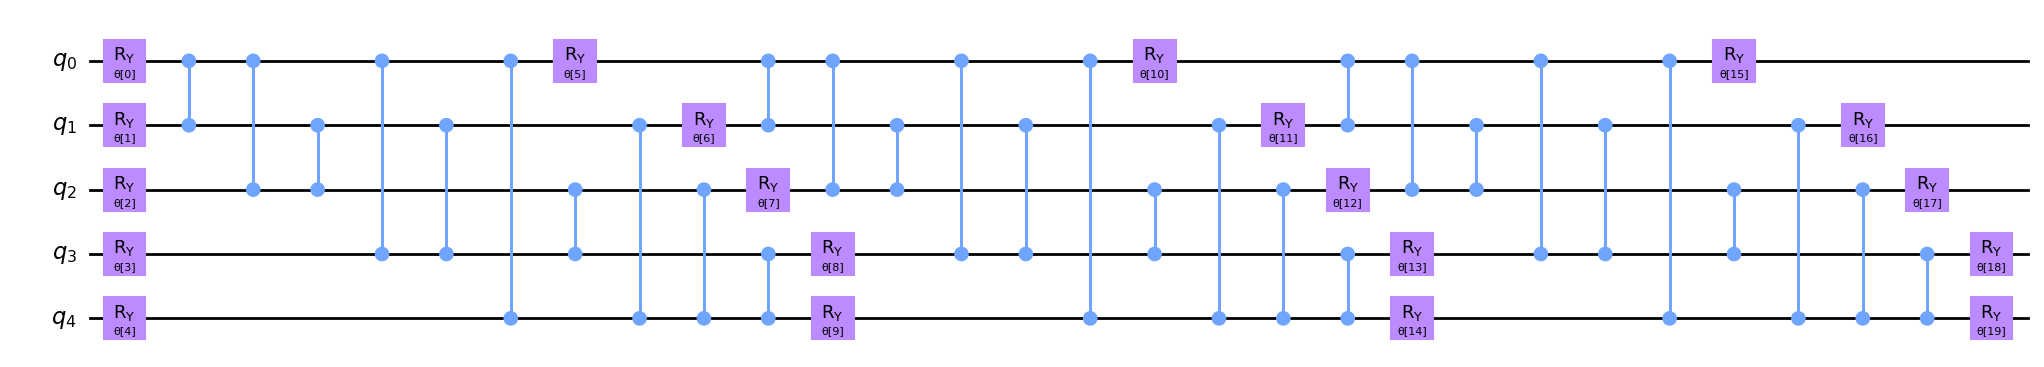

In [12]:
from qiskit.circuit.library import TwoLocal
ansatz = g2(5,1)
ansatz = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
ansatz.decompose().draw('mpl', fold=150)

$\theta$ parameters for this circuit are the ones that need to be trained so that at the end, the solution with highest success probability shows the result to our problem.

In [13]:
from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
ansatz = g2(5,1)
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/1609422378.py:13: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/1609422378.py:14: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)


In [14]:
%%time
import csv
import time
import pandas as pd
from csv import writer
i = 0
with open('cobyla5.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        result = vqe.solve(qp)
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('cobyla5.csv')
print(data1['time'].mean())
print(data1['time'].std())
print_result(result)

0.40357086999999986
0.12916249549795145
Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0]	0.0024		0.7274
[1 0 0 1 0]	0.0016		0.2694
[0 1 1 0 0]	-0.0010		0.0023
[1 0 1 0 0]	-0.0017		0.0009
[1 1 0 1 0]	1.0117		0.0000
[0 1 0 0 0]	1.0095		0.0000
[0 0 0 1 0]	1.0106		0.0000
[1 0 0 0 0]	1.0089		0.0000
[0 1 0 1 1]	1.0139		0.0000
[1 0 0 1 1]	1.0127		0.0000
[0 1 1 1 0]	1.0102		0.0000
[1 0 1 1 0]	1.0094		0.0000
[1 1 1 0 0]	1.0083		0.0000
[0 0 1 0 0]	1.0074		0.0000
[0 1 1 0 1]	1.0101		0.0000
[1 0 1 0 1]	1.0090		0.0000
[1 1 0 0 0]	0.0005		0.0000
[0 0 0 0 0]	4.0363		0.0000
[1 1 0 1 1]	4.0411		0.0000
[0 1 0 0 1]	0.0024		0.0000
[0 0 0 1 1]	0.0038		0.0000
[1 1 1 1 0]	4.0379		0.0000
[1 0 0 0 1]	0.0013		0.0000
[0 0 1 1 0]	0.0001		0.0000
[0 1 1 1 1]	4.0400		0.0000
[1 0 1 1 1]	4.0387		0.0000
[1 1 1 0 1]	4.0374		0.0000
[0 0 1 0 1]	0.0002		0.0000
[1 1 0 0 1]	1.011

At this point it is important we pay attention at the probability column. This column states how plausible it is that using this circuit with found parameters we may found the optimal result. Our candidate solution has relativelly low probability, which means we should find better designs to increase our chances. We can easilly test how it would look like by adding more repetitions to the ansatz.

In [15]:
ansatz = g2(5,1)
#ansatz = TwoLocal(num_assets, "ry", "cz", reps=6, entanglement="full")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/3770655853.py:7: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/3770655853.py:8: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe_mes = VQE(ansatz, optimizer=cobyla, quantum_instance=quantum_instance)


Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0]	0.0024		0.5285
[0 1 1 0 0]	-0.0010		0.4671
[1 0 0 1 0]	0.0016		0.0024
[1 0 1 0 0]	-0.0017		0.0021
[0 1 0 1 1]	1.0139		0.0000
[0 1 1 0 1]	1.0101		0.0000
[1 1 0 1 0]	1.0117		0.0000
[1 1 1 0 0]	1.0083		0.0000
[0 0 0 1 0]	1.0106		0.0000
[0 0 1 0 0]	1.0074		0.0000
[0 1 0 0 0]	1.0095		0.0000
[0 1 1 1 0]	1.0102		0.0000
[1 0 0 1 1]	1.0127		0.0000
[1 0 1 0 1]	1.0090		0.0000
[1 0 0 0 0]	1.0089		0.0000
[1 0 1 1 0]	1.0094		0.0000
[1 1 0 1 1]	4.0411		0.0000
[1 1 1 0 1]	4.0374		0.0000
[0 0 0 1 1]	0.0038		0.0000
[0 0 1 0 1]	0.0002		0.0000
[0 1 0 0 1]	0.0024		0.0000
[1 1 0 0 0]	0.0005		0.0000
[0 1 1 1 1]	4.0400		0.0000
[1 1 1 1 0]	4.0379		0.0000
[0 0 0 0 0]	4.0363		0.0000
[0 0 1 1 0]	0.0001		0.0000
[1 0 0 0 1]	0.0013		0.0000
[1 0 1 1 1]	4.0387		0.0000
[1 1 0 0 1]	1.0113		0.0000
[1 1 1 1 1]	9.0856		0.0000
[0 

In [16]:
%%time
import csv
import time
import pandas as pd
from csv import writer
i = 0
with open('cobyla5_6reps2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        result = vqe.solve(qp)
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('cobyla5_6reps2.csv')
print(data1['time'].mean())
print(data1['time'].std())
print_result(result)

0.4077667599999988
0.1096715488629053
Optimal: selection [0. 0. 1. 0. 1.], value 0.0002

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1]	0.0002		0.9960
[0 0 0 1 1]	0.0038		0.0040
[0 0 0 0 1]	1.0108		0.0000
[1 1 1 0 1]	4.0374		0.0000
[0 0 1 1 1]	1.0115		0.0000
[1 0 1 0 1]	1.0090		0.0000
[0 0 1 0 0]	1.0074		0.0000
[0 1 1 0 1]	1.0101		0.0000
[1 1 0 1 1]	4.0411		0.0000
[1 0 0 1 1]	1.0127		0.0000
[0 0 0 1 0]	1.0106		0.0000
[0 1 0 1 1]	1.0139		0.0000
[1 1 0 0 1]	1.0113		0.0000
[1 1 1 1 1]	9.0856		0.0000
[1 0 0 0 1]	0.0013		0.0000
[0 0 0 0 0]	4.0363		0.0000
[1 1 1 0 0]	1.0083		0.0000
[1 0 1 1 1]	4.0387		0.0000
[0 0 1 1 0]	0.0001		0.0000
[0 1 0 0 1]	0.0024		0.0000
[1 0 1 0 0]	-0.0017		0.0000
[0 1 1 1 1]	4.0400		0.0000
[0 1 1 0 0]	-0.0010		0.0000
[1 1 0 1 0]	1.0117		0.0000
[1 0 0 1 0]	0.0016		0.0000
[0 1 0 1 0]	0.0024		0.0000
[1 1 0 0 0]	0.0005		0.0000
[1 1 1 1 0]	4.0379		0.0000
[1 0 0 0 0]	1.0089		

Right now we reached 20% chances of seeing this state on a single run of our circuit. We could then simulate lets say for 5 runs so that way we most probably would register classically that state at least once.

In [36]:
best_parameters = None
for key, value in vqe_mes.__dict__.items():
    if key == "_ret":
        best_parameters = value.optimal_parameters

We can try with a different approach, in this case QAOA. For that, only number of layers to repeat the canonical form of the ansatz need to be provided.

In [18]:
from qiskit.algorithms import QAOA

layers = 2
qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/642958907.py:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)


Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	0.0038		0.0964
[0 1 0 0 1]	0.0024		0.0962
[0 1 0 1 0]	0.0024		0.0962
[1 0 0 1 0]	0.0016		0.0961
[1 0 0 0 1]	0.0013		0.0960
[1 1 0 0 0]	0.0005		0.0959
[0 0 1 0 1]	0.0002		0.0959
[0 0 1 1 0]	0.0001		0.0958
[0 1 1 0 0]	-0.0010		0.0957
[1 0 1 0 0]	-0.0017		0.0956
[0 0 0 0 0]	4.0363		0.0054
[0 0 1 0 0]	1.0074		0.0042
[0 1 0 0 0]	1.0095		0.0042
[0 0 0 1 0]	1.0106		0.0042
[1 0 0 0 0]	1.0089		0.0042
[0 0 0 0 1]	1.0108		0.0042
[1 1 1 1 1]	9.0856		0.0036
[0 1 0 1 1]	1.0139		0.0010
[1 0 0 1 1]	1.0127		0.0010
[1 1 0 1 0]	1.0117		0.0010
[0 0 1 1 1]	1.0115		0.0010
[0 1 1 1 0]	1.0102		0.0010
[1 1 0 0 1]	1.0113		0.0010
[0 1 1 0 1]	1.0101		0.0010
[1 0 1 1 0]	1.0094		0.0010
[1 1 1 0 0]	1.0083		0.0010
[1 0 1 0 1]	1.0090		0.0010
[1 1 1 0 1]	4.0374		0.0001
[1 1 1 1 0]	4.0379		0.0001
[1 0 1 1 1]	4.0387		0.0001
[0 

In [19]:
%%time
import csv
import time
import pandas as pd
from csv import writer
i = 0
with open('qaoa5_2lay.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        result = qaoa.solve(qp)
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('qaoa5_2lay.csv')
print(data1['time'].mean())
print(data1['time'].std())
print_result(result)

0.6155108099999977
0.27905915418167476
Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 0 0]	1.0083		0.0616
[1 0 1 1 0]	1.0094		0.0614
[1 0 1 0 1]	1.0090		0.0614
[0 1 1 0 1]	1.0101		0.0613
[0 1 1 1 0]	1.0102		0.0613
[0 0 1 1 1]	1.0115		0.0612
[1 1 0 1 0]	1.0117		0.0612
[1 1 0 0 1]	1.0113		0.0611
[1 0 0 1 1]	1.0127		0.0610
[0 1 0 1 1]	1.0139		0.0610
[1 0 1 0 0]	-0.0017		0.0294
[0 1 1 0 0]	-0.0010		0.0293
[0 0 1 0 1]	0.0002		0.0293
[1 1 0 0 0]	0.0005		0.0293
[0 0 1 1 0]	0.0001		0.0293
[1 0 0 0 1]	0.0013		0.0292
[1 0 0 1 0]	0.0016		0.0292
[0 1 0 0 1]	0.0024		0.0292
[0 1 0 1 0]	0.0024		0.0291
[0 0 0 1 1]	0.0038		0.0291
[1 1 1 1 0]	4.0379		0.0165
[1 1 1 0 1]	4.0374		0.0164
[1 0 1 1 1]	4.0387		0.0164
[0 1 1 1 1]	4.0400		0.0164
[1 1 0 1 1]	4.0411		0.0163
[0 0 0 0 0]	4.0363		0.0088
[1 1 1 1 1]	9.0856		0.0014
[0 0 1 0 0]	1.0074		0.0006
[1 0 0 0 0]	1.0089

In [20]:
layers = 5

qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/1447556634.py:3: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)


Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	-0.0017		0.1012
[0 1 1 0 0]	-0.0010		0.1003
[0 0 1 0 1]	0.0002		0.0995
[1 1 0 0 0]	0.0005		0.0993
[0 0 1 1 0]	0.0001		0.0993
[1 0 0 0 1]	0.0013		0.0983
[1 0 0 1 0]	0.0016		0.0983
[0 1 0 0 1]	0.0024		0.0977
[0 1 0 1 0]	0.0024		0.0975
[0 0 0 1 1]	0.0038		0.0969
[0 0 0 0 0]	4.0363		0.0013
[1 1 1 0 0]	1.0083		0.0007
[0 0 0 1 0]	1.0106		0.0007
[1 0 1 1 0]	1.0094		0.0006
[1 0 1 0 1]	1.0090		0.0006
[0 0 0 0 1]	1.0108		0.0006
[0 1 1 0 1]	1.0101		0.0006
[0 1 1 1 0]	1.0102		0.0006
[0 1 0 0 0]	1.0095		0.0006
[0 0 1 1 1]	1.0115		0.0006
[1 1 0 1 0]	1.0117		0.0006
[1 1 0 0 1]	1.0113		0.0006
[1 0 0 0 0]	1.0089		0.0006
[1 0 0 1 1]	1.0127		0.0005
[0 0 1 0 0]	1.0074		0.0005
[0 1 0 1 1]	1.0139		0.0005
[1 1 1 1 1]	9.0856		0.0004
[1 1 1 0 1]	4.0374		0.0002
[1 1 1 1 0]	4.0379		0.0002
[1 0 1 1 1]	4.0387		0.0002
[0 

In [21]:
%%time
import csv
import time
import pandas as pd
from csv import writer
i = 0
with open('qaoa5_5lay.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        result = qaoa.solve(qp)
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('qaoa5_5lay.csv')
print(data1['time'].mean())
print(data1['time'].std())
print_result(result)

1.6348383549999979
0.10118209496928086
Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	0.0038		0.1002
[0 1 0 1 0]	0.0024		0.0996
[0 1 0 0 1]	0.0024		0.0996
[1 0 0 1 0]	0.0016		0.0992
[1 0 0 0 1]	0.0013		0.0990
[1 1 0 0 0]	0.0005		0.0988
[0 0 1 1 0]	0.0001		0.0986
[0 0 1 0 1]	0.0002		0.0986
[0 1 1 0 0]	-0.0010		0.0982
[1 0 1 0 0]	-0.0017		0.0979
[0 0 1 0 0]	1.0074		0.0018
[1 0 0 0 0]	1.0089		0.0017
[0 1 0 0 0]	1.0095		0.0017
[0 0 0 0 1]	1.0108		0.0017
[0 0 0 1 0]	1.0106		0.0017
[0 0 0 0 0]	4.0363		0.0003
[1 1 0 1 1]	4.0411		0.0002
[0 1 1 1 1]	4.0400		0.0002
[1 0 1 1 1]	4.0387		0.0002
[1 1 1 0 1]	4.0374		0.0002
[1 1 1 1 0]	4.0379		0.0001
[1 1 1 1 1]	9.0856		0.0001
[0 1 0 1 1]	1.0139		0.0001
[1 0 0 1 1]	1.0127		0.0000
[1 1 0 1 0]	1.0117		0.0000
[0 0 1 1 1]	1.0115		0.0000
[1 1 0 0 1]	1.0113		0.0000
[1 1 1 0 0]	1.0083		0.0000
[0 1 1 0 1]	1.0101

In this case, the depth of the circuit did not make much in favor of our outcome as the chances of getting the optimal solution decreased from almost 8% to 6%.

In [22]:
layers = 1

qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

/var/folders/9k/xq3jd5c90w93s6tc_cws222r0000gn/T/ipykernel_66107/2620542453.py:3: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa_mes = QAOA(optimizer=cobyla, reps=layers, quantum_instance=quantum_instance)


Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	-0.0017		0.0314
[0 1 1 0 0]	-0.0010		0.0314
[0 0 1 1 0]	0.0001		0.0314
[0 0 1 0 1]	0.0002		0.0314
[1 1 0 0 0]	0.0005		0.0314
[1 0 0 0 1]	0.0013		0.0314
[1 0 0 1 0]	0.0016		0.0314
[0 1 0 1 0]	0.0024		0.0314
[0 1 0 0 1]	0.0024		0.0314
[0 0 0 1 1]	0.0038		0.0314
[0 0 0 0 0]	4.0363		0.0314
[1 1 1 1 0]	4.0379		0.0314
[1 1 1 0 1]	4.0374		0.0314
[1 0 1 1 1]	4.0387		0.0314
[0 1 1 1 1]	4.0400		0.0314
[1 1 0 1 1]	4.0411		0.0314
[1 1 1 1 1]	9.0856		0.0311
[0 1 0 1 1]	1.0139		0.0311
[1 0 0 1 1]	1.0127		0.0311
[1 1 0 0 1]	1.0113		0.0311
[1 1 0 1 0]	1.0117		0.0311
[0 0 1 1 1]	1.0115		0.0311
[0 1 1 0 1]	1.0101		0.0311
[0 1 1 1 0]	1.0102		0.0311
[1 0 1 0 1]	1.0090		0.0311
[1 0 1 1 0]	1.0094		0.0311
[1 1 1 0 0]	1.0083		0.0311
[0 0 0 1 0]	1.0106		0.0311
[0 0 0 0 1]	1.0108		0.0311
[0 1 0 0 0]	1.0095		0.0311
[1 

In [23]:
%%time
import csv
import time
import pandas as pd
from csv import writer
i = 0
with open('qaoa5_1lay.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        result = qaoa.solve(qp)
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('qaoa5_1lay.csv')
print(data1['time'].mean())
print(data1['time'].std())
print_result(result)

0.16243177700000114
0.12839238079741733
Optimal: selection [1. 0. 1. 0. 0.], value -0.0017

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	-0.0017		0.0658
[0 1 1 0 0]	-0.0010		0.0658
[0 0 1 1 0]	0.0001		0.0656
[0 0 1 0 1]	0.0002		0.0656
[1 1 0 0 0]	0.0005		0.0655
[1 0 0 0 1]	0.0013		0.0654
[1 0 0 1 0]	0.0016		0.0654
[0 1 0 1 0]	0.0024		0.0653
[0 1 0 0 1]	0.0024		0.0653
[0 0 0 1 1]	0.0038		0.0651
[0 0 1 0 0]	1.0074		0.0231
[1 0 0 0 0]	1.0089		0.0230
[0 1 0 0 0]	1.0095		0.0229
[0 0 0 1 0]	1.0106		0.0229
[0 0 0 0 1]	1.0108		0.0228
[1 1 1 0 0]	1.0083		0.0221
[1 0 1 0 1]	1.0090		0.0221
[1 0 1 1 0]	1.0094		0.0220
[0 1 1 0 1]	1.0101		0.0220
[0 1 1 1 0]	1.0102		0.0220
[1 1 0 0 1]	1.0113		0.0219
[0 0 1 1 1]	1.0115		0.0219
[1 1 0 1 0]	1.0117		0.0219
[1 0 0 1 1]	1.0127		0.0218
[0 1 0 1 1]	1.0139		0.0217
[1 1 1 1 1]	9.0856		0.0043
[0 0 0 0 0]	4.0363		0.0031
[1 1 0 1 1]	4.0411		0.0008
[0 1 1 1 1]	4.040

As it also happends with classical ML and QML approaches, design is key for solving the problem with a high success rate for obtaining the best possible solution. Lets run our best solution up to now and see how the outcome would look like.

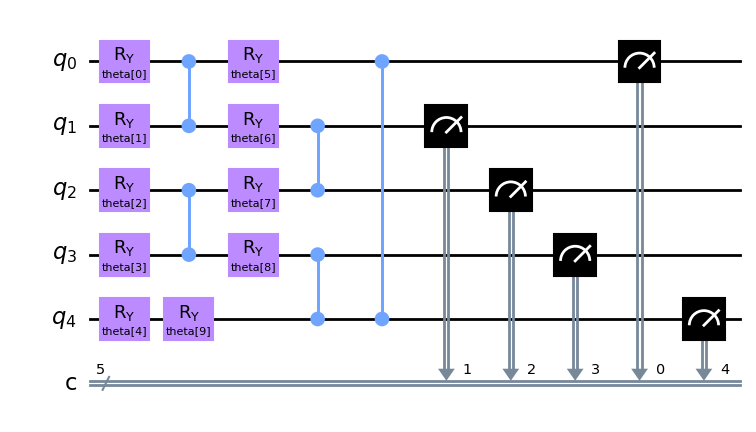

In [30]:
from qiskit import QuantumCircuit
ansatz = g2(5,1)
qc = QuantumCircuit(num_assets,num_assets)

# VQE Two Local ansatz
qc.compose(ansatz, inplace=True)

# Measures
for i in range(0, num_assets):
    qc.measure(i, i)

qc.draw('mpl', fold=150)

In [32]:
pqc = qc.bind_parameters(best_parameters)
pqc.draw('mpl', fold=150)

CircuitError: 'Cannot bind parameters (theta[8], theta[9], theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7]) not present in the circuit.'

In [33]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

# Number of shots to the circuit
nshots = 10

# execute the quantum circuit
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(pqc, backend, shots=nshots).result()
counts  = result.get_counts(pqc)

plot_histogram(counts)

NameError: name 'pqc' is not defined

In [ ]:

print("Solutions found:")
for cres in counts:
    print(f"Solution {cres[::-1]} with success probability {counts[cres]*100/nshots}%")

In [39]:
len(g2(5,1).parameters)

10

In [40]:
best_parameters

{ParameterVectorElement(theta[0]): -3.1415215275636363,
 ParameterVectorElement(theta[1]): 2.0563398461898847,
 ParameterVectorElement(theta[2]): -3.014908539359386,
 ParameterVectorElement(theta[3]): -4.799710474304674,
 ParameterVectorElement(theta[4]): 5.085186546636373,
 ParameterVectorElement(theta[5]): -3.1415989091366194,
 ParameterVectorElement(theta[6]): 2.0563569430976507,
 ParameterVectorElement(theta[7]): 6.2719889605147765,
 ParameterVectorElement(theta[8]): 1.4828278508942077,
 ParameterVectorElement(theta[9]): -1.9435558028623277}